In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

import requests 
import json

In [2]:
key_bea = '3E7CB4CE-838D-4BB0-AE7C-9BACB931D976'
base_url_bea = 'http://apps.bea.gov/api/data?UserID=' + key_bea + '&method=GetData' 
res_f_bea = '&ResultFormat=JSON'

# Helper function to filter BEA data
def get_url(table_name, frequency='Q', database='NIPA'):
    url = base_url_bea + '&DataSetName=' + database + '&TableName=' + table_name + \
          '&Frequency=' + frequency + '&Year=X'+ res_f_bea
    
    return url

def filter_data(results, col_name_in, col_name_out, year_begin=1960):
    data = pd.read_json(json.dumps(results))
    data['TimePeriod'] = pd.to_datetime(data['TimePeriod'].astype(str))
    data = data.loc[data['LineDescription'] == col_name_in][['DataValue', 'TimePeriod']]
    data['TimePeriod'] = pd.to_datetime(data['TimePeriod'])
    data = data.loc[data['TimePeriod'] >= (str(year_begin) + '-01-01')]\
            .rename(columns={'DataValue': col_name_out, 'TimePeriod': 'date'})\
            .set_index('date')

    # Commas are a thousands separator, pandas somehow doesn't get it - fix this manually
    if data.dtypes[col_name_out] == np.dtype('object'):
        data[col_name_out] = pd.to_numeric(data[col_name_out].str.replace(',', ''))
    
    return data

def get_table(table_name, col_name_in, col_name_out, frequency='Q', 
              database='NIPA', filter = True):
    r = requests.get(get_url(table_name, frequency, database))
    if filter:
        data = filter_data(r.json()['BEAAPI']['Results']['Data'], col_name_in, col_name_out)
    else:
        data = r.json()
        
    return data

def check_series(table_name, frequency='Q', database='NIPA'):
    r = requests.get(get_url(table_name, frequency, database))
    data = r.json()['BEAAPI']['Results']['Data']
    return set([x['LineDescription'] for x in data])

In [3]:
key_fred = '12ae65528f24e8974f32c172f44c3ee5'
base_url_fred = 'https://api.stlouisfed.org/fred/series/observations?' 'api_key=' +\
                key_fred + '&file_type=json' 

# Helper function to filter FRED data
def get_url_fred(table_name):
    url = base_url_fred + '&series_id=' + table_name
    return url

def get_table_fred(table_name, col_name_out):
    r = requests.get(get_url_fred(table_name))
    data = pd.read_json(json.dumps(r.json()['observations']))[['date', 'value']]
    data = data.set_index('date').rename(columns={'value': col_name_out})
    
    return data

In [4]:
# Get GDP
data = get_table('T10106', 'Gross domestic product', 'GDP')

# Gov spending
data = data.join(get_table('T10106', 'Government consumption expenditures and gross investment', 
                          'gov_spending'))

# Housing services
data = data.join(get_table('T20305', 'Housing and utilities', 'housing_services'))

# Housing deflator
data = data.join(get_table('T20304', 'Housing and utilities', 'housing_services_deflator'))

# Real housing services
data['real_housing'] = data['housing_services']/(data['housing_services_deflator']/100)

# Private non-res output
data['y'] = data['GDP'] - data['real_housing'] - data['gov_spending']

In [5]:
# Nom. priv. non-res. fixed inv.
data = data.join(get_table('T50305', 'Private fixed investment', 'pr_fix_inv_nom'))

# Deflator for Nom. priv. non-res. fixed inv.
data = data.join(get_table('T50304', 'Private fixed investment', 'pr_fix_inv_def'))

# Real priv. non-res. fixed inv. (divide by 1000 to fix)
data['pr_fix_inv'] = (data['pr_fix_inv_nom']/1000)/(data['pr_fix_inv_def']/100)

In [6]:
# Get annual private non-residential fixed assets
an_data = get_table('FAAt401', 'Private nonresidential fixed assets', 'fixed_assets', 
                    frequency = 'A', database = 'FixedAssets')

# Chain-type quantity index for private non-residential fixed assets
an_data = an_data.join(get_table('FAAt402', 'Private nonresidential fixed assets', 'fa_index', 
                    frequency = 'A', database = 'FixedAssets'))

# Real fixed assets
an_data['fixed_assets_real'] = an_data['fixed_assets']/(an_data['fa_index']/100)

# Quarterly interpolation (linear interpolation)
data = data.join(an_data['fixed_assets_real']).interpolate()

In [7]:
# Depreciation rates
K = data['fixed_assets_real']
I = data['pr_fix_inv']
data['depr'] = 1 - ((K-I)/K.shift(-1))**4

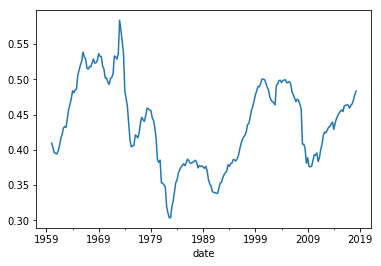

In [8]:
# Plot Depreciation
fig, ax = plt.subplots(figsize = (6,4))

data['depr'].plot(ax=ax)
fig.savefig("depr.pdf")

In [9]:
# Payroll
fred = get_table_fred('USPRIV', 'payroll')

# Avg each quarter
data = data.join(fred.rolling(window=3).mean().shift(-3))

In [10]:
# Labor income
data = data.join(get_table('T11000', 'Compensation of employees, paid', 'inc_labor'))

# Private capital income
data = data.join(get_table('T11000', 'Net operating surplus', 'inc_capital_1'))
data = data.join(get_table('T11000', 'Consumption of fixed capital', 'inc_capital_2'))

# Labor share
i_l = data['inc_labor']
i_k = data['inc_capital_1'] + data['inc_capital_2']
data['labor_share'] = i_l/(i_l + i_k)

In [11]:
# Construct Sollow residual
a = data['labor_share']
y = data['y']
n = data['payroll']
k = data['fixed_assets_real']

data['log_A'] = np.log(y) - a*np.log(n) - (1-a)*np.log(k)

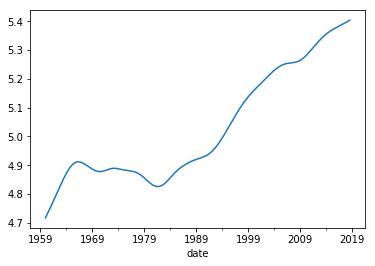

In [15]:
# HP filter
cycle, trend = sm.tsa.filters.hpfilter(data.log_A, 1600)

fig, ax = plt.subplots(figsize = (6,4))

trend.plot(ax=ax)
fig.savefig("A_cycle.pdf")

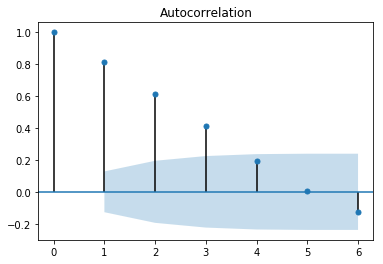

In [13]:
fig, ax = plt.subplots(figsize = (6,4))

plot_acf(cycle, lags=6, ax=ax)
fig.savefig("A_cycle_acf.pdf")